#### This notebook create MIMIC cut with hypotensive patients following the paper http://proceedings.mlr.press/v119/gottesman20a.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from pipeline_utils import *
import pickle
import re
import random
data_path = '/home/jiayu/Desktop/misc/mimic-iv/query_data/' # change data path accordingly
resource_path = '/home/jiayu/Desktop/mimic-pipeline-tools/mimic-iv-v2-0/resources/' # change resource path accordingly
saving_dir = 'curated_data/'

In [2]:
def to_interval(istr):
    c_left = istr[0]=='['
    c_right = istr[-1]==']'
    closed = {(True, False): 'left',
              (False, True): 'right',
              (True, True): 'both',
              (False, False): 'neither'
              }[c_left, c_right]
    left, right = map(pd.to_datetime, istr[1:-1].split(','))
    return pd.Interval(left, right, closed)

### Load in static_data.csv and convert all features to the right datatype
Argument:

    data_path -- path of mimic data directory 
    resource_path -- resource directory of mimic-pipeline-tools/mimic-iv-v2-0 repo

Return:

    data_df -- dataframe of static info

In [3]:
static_df = load_static_df(data_path, resource_path)

### Plot histogram 
A quick overview of demographic info

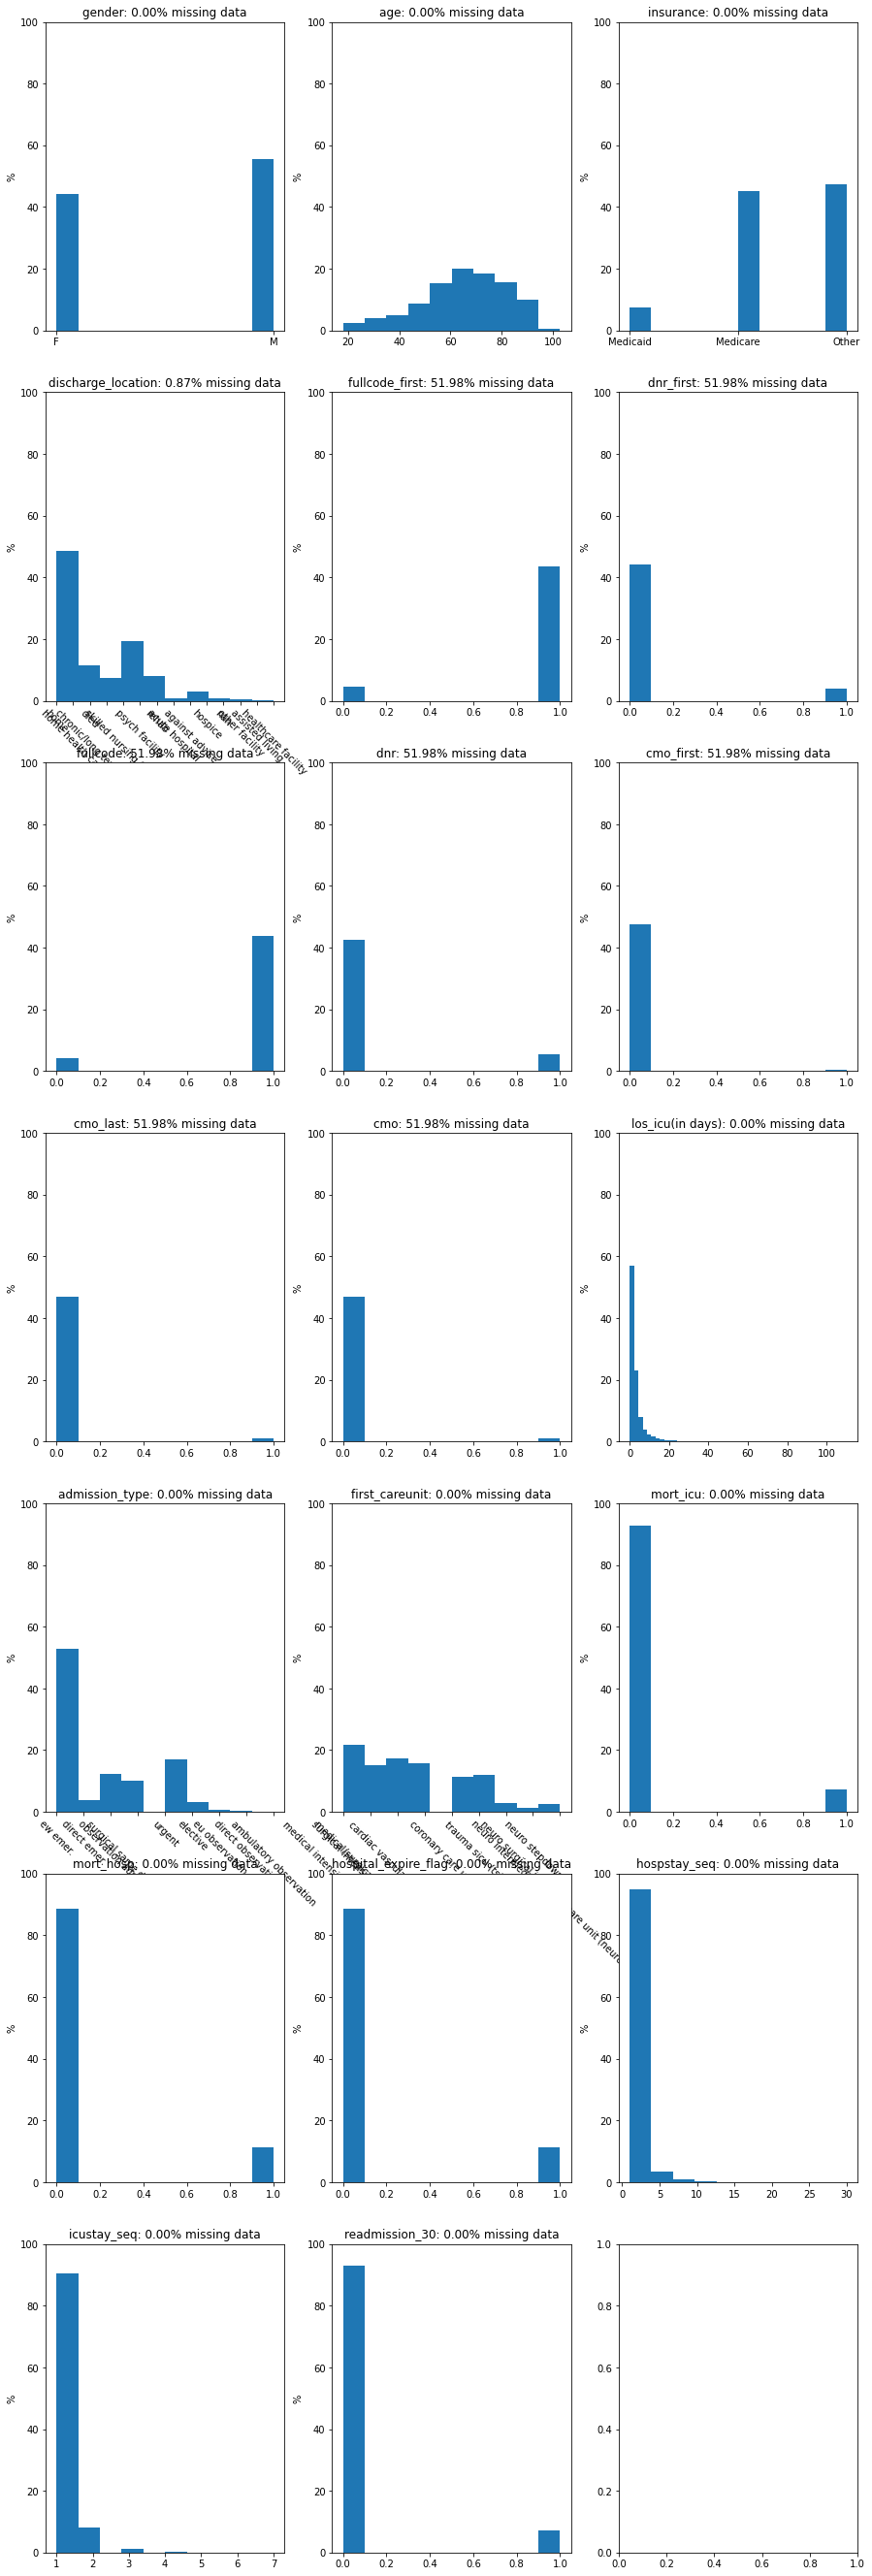

In [4]:
def plot_hist_static(df):
    fig, axs = plt.subplots(7,3,figsize=(15,48))
    i = 0
    for f in df.columns[2:]:
        title_f = f
#         if f == 'discharge_location': continue
        if df[f].dtype.name=='datetime64[ns]': continue
        elif f=='los_icu':
            axs[i//3][i%3].hist(df[f],weights=w, bins = 50)
            title_f = 'los_icu(in days)'
        elif df[f].dtype.name=='category' or df[f].dtype.name=='object':
            w = np.ones(len(df))/len(df)*100
            if f=='race':
                continue
            elif f in ['race_regroup','admission_type','first_careunit']:
                axs[i//3][i%3].hist(df[f].str.lower(),weights=w)
                axs[i//3][i%3].tick_params(axis='x',labelrotation=-45)
            elif f=='discharge_location':
                axs[i//3][i%3].hist(df.discharge_location.fillna('nan').str.lower(),weights=w)
                axs[i//3][i%3].tick_params(axis='x',labelrotation=-45)


            else:
                axs[i//3][i%3].hist(df[f],weights=w)
                    
        else:
            axs[i//3][i%3].hist(df[f].dropna(),weights=np.ones(len(df[f].dropna()))/len(df[f])*100)
        axs[i//3][i%3].set_title('{}: {:.2f}% missing data'.format(title_f,100.-len(df[f].dropna())/len(df[f])*100))
        axs[i//3][i%3].set_ylim([0.,100.])
        axs[i//3][i%3].set_ylabel('%')
        
        i+=1
    plt.show()
plot_hist_static(static_df)

### Select patient cohort based on following args
Argument:
 
    df -- static dataframe to be filtered
    min_age -- 18
    max_age -- 80
    min_duration -- 24
    max_duration -- None
    icustay_seq -- first time of admission icu 

Output:

    df -- filtered static dataframe (# 43292) patient in total

    



In [5]:
selected_static_df = select_patient_cohort(static_df, min_age = 18, max_age = 80, min_duration = 24,max_duration = None,\
                                 hosq_seq = None, icustay_seq=1,\
                                 mort_hosp=None, mort_icu=None, readmission_30=None)

print ('{} patients selected'.format(len(selected_static_df)))
display(selected_static_df)

43292 patients selected


,subject_id,hadm_id,gender,race,age,insurance,admittime,dischtime,discharge_location,fullcode_first,...,icu_outtime,los_icu,admission_type,first_careunit,mort_icu,mort_hosp,hospital_expire_flag,hospstay_seq,icustay_seq,readmission_30
stay_id,,,,,,,,,,,,,,,,,,,,,
37067082,10001217,24597018,F,WHITE,55.881486,Other,2157-11-18 22:56:00,2157-11-25 18:00:00,HOME HEALTH CARE,NaN,...,2157-11-21 22:08:00,1.12,EW EMER.,Surgical Intensive Care Unit (SICU),0,0,0,1,1,0
31205490,10001725,25563031,F,WHITE,46.275517,Other,2110-04-11 15:08:00,2110-04-14 15:00:00,HOME,1.0,...,2110-04-12 23:59:56,1.34,EW EMER.,Medical/Surgical Intensive Care Unit (MICU/SICU),0,0,0,1,1,0
37510196,10001884,26184834,F,BLACK/AFRICAN AMERICAN,77.018296,Medicare,2131-01-07 20:39:00,2131-01-20 05:15:00,DIED,NaN,...,2131-01-20 08:27:30,9.17,OBSERVATION ADMIT,Medical Intensive Care Unit (MICU),1,1,1,1,1,0
39060235,10002013,23581541,F,OTHER,57.378803,Medicare,2160-05-18 07:45:00,2160-05-23 13:30:00,HOME HEALTH CARE,1.0,...,2160-05-19 17:33:33,1.31,SURGICAL SAME DAY ADMISSION,Cardiac Vascular Intensive Care Unit (CVICU),0,0,0,1,1,0
39638202,10002223,22494570,M,UNABLE TO OBTAIN,21.039243,Other,2158-01-15 08:00:00,2158-01-20 19:29:00,HOME,1.0,...,2158-01-16 15:19:24,1.30,EW EMER.,Trauma SICU (TSICU),0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37364566,19999297,21439025,M,MULTIPLE RACE/ETHNICITY,42.618758,Other,2162-08-14 23:55:00,2162-08-23 04:16:00,DIED,NaN,...,2162-08-23 06:22:41,7.02,OBSERVATION ADMIT,Medical Intensive Care Unit (MICU),1,1,1,1,1,0
32336619,19999442,26785317,M,WHITE,43.884161,Medicaid,2148-11-19 10:00:00,2148-12-04 16:25:00,REHAB,1.0,...,2148-11-26 13:12:15,6.95,ELECTIVE,Surgical Intensive Care Unit (SICU),0,0,0,1,1,0
36075953,19999828,25744818,F,WHITE,48.022487,Other,2149-01-08 16:44:00,2149-01-18 17:00:00,HOME HEALTH CARE,NaN,...,2149-01-10 13:11:02,1.79,EW EMER.,Medical Intensive Care Unit (MICU),0,0,0,1,1,0


### aggregate demographic info, comorbidity scores and sepsis label
Argument:

    data_path -- str: path of data folder
    df -- dataframe: static info dataframe
    demo_features -- No demographic features included
    comorbidity -- No commorbidity included
    include_sepsis -- False

Return:

    df -- dataframe aggregating demographic info, comorbidity scores and sepsis label

In [6]:
# specifiy static features which include demographic, sepsis definition, commorbidity score, first day measurements

# valid option: every column inside static_data.csv 
# demo_features = ['age','gender','race_regroup','insurance','los_icu']

# valid option: 'charlson' and other scores used to caculate cci (columns charlson.csv)
# comorbidity = ['charlson_comorbidity_index','dementia','congestive_heart_failure']
# if include sepsis label
demo_features = None
comorbidity = None
include_sepsis = False

selected_static_df = aggr_static(data_path, selected_static_df,demo_features=demo_features,\
                                 comorbidity=comorbidity,include_sepsis=include_sepsis)
display(selected_static_df)

Finished concat comorbidity scores... 
Finished concat sepsis labels... 


/home/jiayu/Desktop/mimic-pipeline-tools/mimic-iv-v2-0/pipeline_utils.py:62: UserWarning: Demographic feature not specified; None demographic feature selected
  warnings.warn('Demographic feature not specified; None demographic feature selected')


,subject_id,hadm_id,icu_intime,icu_outtime
stay_id,,,,
37067082,10001217,24597018,2157-11-20 19:18:02,2157-11-21 22:08:00
31205490,10001725,25563031,2110-04-11 15:52:22,2110-04-12 23:59:56
37510196,10001884,26184834,2131-01-11 04:20:05,2131-01-20 08:27:30
39060235,10002013,23581541,2160-05-18 10:00:53,2160-05-19 17:33:33
39638202,10002223,22494570,2158-01-15 08:01:49,2158-01-16 15:19:24
...,...,...,...,...
37364566,19999297,21439025,2162-08-16 05:48:32,2162-08-23 06:22:41
32336619,19999442,26785317,2148-11-19 14:23:43,2148-11-26 13:12:15
36075953,19999828,25744818,2149-01-08 18:12:00,2149-01-10 13:11:02


### Load in variable range table
Note: for now, we are using the same resource file as that in MIMIC-III; modify (add more variables in the future) if needed; 

Argument: 

    resource_path -- path of resource folder
Return:

    var_range -- table of variable ranges



In [7]:
variable_range_df = get_variable_ranges(resource_path)
display(variable_range_df)

,OUTLIER_LOW,VALID_LOW,IMPUTE,VALID_HIGH,OUTLIER_HIGH
VARIABLE,,,,,
alanine_aminotransferase,0.0,2.00,34.00,10000.00,11000.0
albumin,0.0,0.60,3.10,6.00,60.0
alkaline_phosphate,0.0,20.00,106.00,3625.00,4000.0
anion_gap,0.0,5.00,13.00,50.00,55.0
asparate_aminotransferase,0.0,6.00,40.00,20000.00,22000.0
bicarbonate,0.0,0.00,25.00,60.00,66.0
bilirubin,0.0,0.10,0.90,60.00,66.0
blood_urea_nitrogen,0.0,0.00,23.00,250.00,275.0
capillary_refill_rate,0.0,0.00,0.00,1.00,1.0


#### Select patients with 7 or more MAP values of 65mmHg or less

In [8]:
selected_static_df

,subject_id,hadm_id,icu_intime,icu_outtime
stay_id,,,,
37067082,10001217,24597018,2157-11-20 19:18:02,2157-11-21 22:08:00
31205490,10001725,25563031,2110-04-11 15:52:22,2110-04-12 23:59:56
37510196,10001884,26184834,2131-01-11 04:20:05,2131-01-20 08:27:30
39060235,10002013,23581541,2160-05-18 10:00:53,2160-05-19 17:33:33
39638202,10002223,22494570,2158-01-15 08:01:49,2158-01-16 15:19:24
...,...,...,...,...
37364566,19999297,21439025,2162-08-16 05:48:32,2162-08-23 06:22:41
32336619,19999442,26785317,2148-11-19 14:23:43,2148-11-26 13:12:15
36075953,19999828,25744818,2149-01-08 18:12:00,2149-01-10 13:11:02


In [9]:
# selected_static_df = selected_static_df.iloc[:500]
all_maps,_ = aggr_dynamic_features(['mean_blood_pressure(arterial)'],selected_static_df.index, data_path,variable_range_df, exlusion='valid',lq=0.0,hq=1.,imputation_stats=None )
# map values <= 65
all_maps = all_maps[all_maps.mean_blood_pressure<=65]

print (len(all_maps))
icuids  = []
map_ts = {}
for i, icuid in enumerate(np.unique(all_maps.index.get_level_values(0))):
    starttime = selected_static_df.loc[icuid].icu_intime
    endtime = starttime + pd.Timedelta(hours=48)
    ts = pd.to_datetime(all_maps.loc[icuid].index)
    msks = (ts>=starttime) & (ts<endtime)
    if (msks.sum()>= 7):
        icuids.append(icuid)
        map_ts[str(icuid)] = ts[msks]
#         print (len(ts),len(map_ts[str(icuid)]))
print (len(icuids))
# all_maps = all_maps.drop(index=drop_idx)
# print (len(all_maps))

# display(all_maps)
# icuids = list(all_maps.index.get_level_values(0))

# g = all_maps.groupby('stay_id').size()
# # measurements >= 7
# g = g[g>=7]
# print ('#{} patients selected'.format(len(selected_static_df)))
# display(selected_static_df)

Using None as imputation stats
finish reading mean_blood_pressure.csv
Dropping values that are 999999.0
selected level 1: mean blood pressure (arterial)
	 0.6167102068024893% data excluded
273953
5939


#### Help function to load treatments and exclude extreme values
Arguments

    data_path -- path of data folder
    icuids -- list of icuids to be included
    treatments -- list of treatments names; all files in treatments/ are valid options

Return

    tr_df -- dictionary with treatment names as keys and treatment dataframes as values


In [10]:
treatments = [
    'norepinephrine',  # --vaso
    'vasopressin',  # --vaso
    'phenylephrine',  # --vaso
    'dopamine', # --vaso
    'epinephrine',  # --vaso
    'crystalloid_bolus',
    'colloid_bolus',
    ]

In [11]:
tr_df = load_treatments(data_path,icuids, treatments)

finish reading norepinephrine.csv
finish reading vasopressin.csv
finish reading phenylephrine.csv
finish reading dopamine.csv
finish reading epinephrine.csv
finish reading crystalloid_bolus.csv
finish reading colloid_bolus.csv


### Aggregate all dynamic features
Arguments

    features -- dynamic feature list; if level 1 desired, speicify it with (level1) with no bracket between (e.g. mean_blood_pressure(arterial)); all files in vitals_and_labs/ are valid options
    icuids -- icuids from selected patient cohort
    variable_ranges -- variable range/impute value table
    data_path -- data path
    exclusion ---- ways to exclue outliers (not all variables have ranges specified)
              ---- default none: include all
              ---- outlier: exclude extreme(nearly impossible) feature valuenums
              ---- valid: exclude rare (but possible) feature valuenums
              (Note: not all variables have a range specified in the table
               if not specified, we use quantile (lq/hq) as exclusion criterion)
    lq -- exlude data lower than low quantile value (default 0)
    hq -- exlude data lower than low quantile value (default 1)
    imputation_stats ---- statistics to store in the imputation table (default mean)
                     ---- mean
                     ---- median



 Return
 
    union_df -- unioned dynamic feature table with ['stay_id','charttime'] as index (table contains lots of nans, which we will fix it later)
    impute_tb -- imputation value table (if not in table, use mean)



### Specify static features, dynamic features, treatment to be included

In [14]:
vitals_and_labs = [
            'creatinine',
            'fraction_inspired_oxygen',
            'lactate',
            'urine_output',
            'alanine_aminotransferase',
            'asparate_aminotransferase',
            'mean_blood_pressure',
            'diastolic_blood_pressure',
            'systolic_blood_pressure',
            'gcs',
            'partial_pressure_of_oxygen',
            'heart_rate',
            'temperature',
            'respiratory_rate'
            ]



In [15]:
union_df,impute_tb = aggr_dynamic_features(vitals_and_labs,icuids, data_path,variable_range_df, exlusion='valid',lq=0.05,hq=0.95,imputation_stats='mean' )

Using mean as imputation stats
finish reading creatinine.csv
Dropping values that are 999999.0
	 0.0004187907057345841% data excluded
finish reading fraction_inspired_oxygen.csv
Dropping values that are 999999.0
	 0.002365099060368303% data excluded
finish reading lactate.csv
Dropping values that are 999999.0
	 0.00025842714777191134% data excluded
finish reading urine_output.csv
Dropping values that are 999999.0
	 0.0010260236918198107% data excluded
finish reading alanine_aminotransferase.csv
Dropping values that are 999999.0
	 0.0009665467432744546% data excluded
finish reading asparate_aminotransferase.csv
Dropping values that are 999999.0
	 0.0017709563164108877% data excluded
finish reading mean_blood_pressure.csv
Dropping values that are 999999.0
	 0.001146647694979741% data excluded
finish reading diastolic_blood_pressure.csv
Dropping values that are 999999.0
	 8.076626243647134e-05% data excluded
finish reading systolic_blood_pressure.csv
Dropping values that are 999999.0
	 1.

In [16]:
impute_tb

{'creatinine': 1.0,
 'fraction_inspired_oxygen': 0.21,
 'lactate': 1.8,
 'urine_output': 80.0,
 'alanine_aminotransferase': 34.0,
 'asparate_aminotransferase': 40.0,
 'mean_blood_pressure': 77.0,
 'diastolic_blood_pressure': 59.0,
 'systolic_blood_pressure': 118.0,
 'gcs': 11.0,
 'partial_pressure_of_oxygen': 112.0,
 'heart_rate': 86.0,
 'temperature': 37.0,
 'respiratory_rate': 19.0}

#### Update patient id list

In [17]:
icuids = list((set(union_df.index.get_level_values(0))))
print (len(icuids))

5939


#### Aggregate vitals and labs with static features (if any) and treatments (if any); 

Arguments
 
    dyn_df -- big union table of all vitals and labs from previous step
    impute_tb -- Table of imputation values
    static_df -- static info dataframe (default none)
    tr_df -- treatment dataframe dictionary from previous step (default {})
    traj_cut -- if cut trajectory to certain length (default 100,000, which is large enough to keep all)
    t_w -- feature binning time window length in hour (default 1)
    start_ts -- starting timestamp (if admit, using icu admission time; if treatment, use timestamp of first treatment; default treatment)
    binning -- how to bin treatment (irregular versus regular; default: irregular)
    norm_treatment -- if normalizing and aggregate treatment dosage, including vaso and fluid 
                           (default true; note not all vasos are implemented)
    fill_na -- if filling nans (if true use forward filling; if there are still nans, use impute table )





In [19]:

aggr_df = feature_aggr(union_df, \
                       impute_tb, \
                       icuids, \
                       start_ts='admit',\
                       static_df=selected_static_df,\
                       t_w=1.,
                       binning='irregular',
                       tr_df = tr_df,
                       fill_na = False,
                       traj_cut = 72,
                       norm_treatment=True)
display(aggr_df)

Finish process # 499 patients
Finish process # 999 patients
Finish process # 1499 patients
Finish process # 1999 patients
Finish process # 2499 patients
Finish process # 2999 patients
Finish process # 3499 patients
Finish process # 3999 patients
Finish process # 4499 patients
Finish process # 4999 patients
Finish process # 5499 patients
normalizing norepinephrine ...
normalizing vasopressin ...
normalizing phenylephrine ...
normalizing dopamine ...
normalizing epinephrine ...
normalizing crystalloid_bolus ...
normalizing colloid_bolus ...


creatinine  \
stay_id  time                                                     
38371329 [2163-01-15 22:15:33, 2163-01-15 23:15:33)         NaN   
         [2163-01-15 23:15:33, 2163-01-16 00:15:33)         1.3   
         [2163-01-16 00:15:33, 2163-01-16 01:15:33)         NaN   
         [2163-01-16 01:15:33, 2163-01-16 02:15:33)         NaN   
         [2163-01-16 02:15:33, 2163-01-16 03:15:33)         NaN   
...                                                         ...   
30769149 [2133-07-22 11:40:43, 2133-07-22 12:40:43)         NaN   
         [2133-07-22 12:40:43, 2133-07-22 13:40:43)         NaN   
         [2133-07-22 13:40:43, 2133-07-22 14:40:43)         NaN   
         [2133-07-22 14:40:43, 2133-07-22 15:40:43)         NaN   
         [2133-07-22 15:40:43, 2133-07-22 16:40:43)         NaN   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
38371329 [2163-01-15 22:15:33, 2163-01-15 23:15:33)                       NaN   
         [2163-01-15 23:15:33, 2163-01-16 00:15:33)                       NaN   
         [2163-01-16 00:15:33, 2163-01-16 01:15:33)                       NaN   
         [2163-01-16 01:15:33, 2163-01-16 02:15:33)                       NaN   
         [2163-01-16 02:15:33, 2163-01-16 03:15:33)                       NaN   
...                                                                       ...   
30769149 [2133-07-22 11:40:43, 2133-07-22 12:40:43)                       0.4   
         [2133-07-22 12:40:43, 2133-07-22 13:40:43)                       NaN   
         [2133-07-22 13:40:43, 2133-07-22 14:40:43)                       NaN   
         [2133-07-22 14:40:43, 2133-07-22 15:40:43)                       NaN   
         [2133-07-22 15:40:43, 2133-07-22 16:40:43)                       NaN   

                                                     lactate  urine_output  \
stay_id  time                                                                
38371329 [2163-01-15 22:15:33, 2163-01-15 23:15:33)      NaN           NaN   
         [2163-01-15 23:15:33, 2163-01-16 00:15:33)      NaN           NaN   
         [2163-01-16 00:15:33, 2163-01-16 01:15:33)      NaN           NaN   
         [2163-01-16 01:15:33, 2163-01-16 02:15:33)      NaN           NaN   
         [2163-01-16 02:15:33, 2163-01-16 03:15:33)      NaN           NaN   
...                                                      ...           ...   
30769149 [2133-07-22 11:40:43, 2133-07-22 12:40:43)      NaN           NaN   
         [2133-07-22 12:40:43, 2133-07-22 13:40:43)      NaN         250.0   
         [2133-07-22 13:40:43, 2133-07-22 14:40:43)      NaN           NaN   
         [2133-07-22 14:40:43, 2133-07-22 15:40:43)      NaN         250.0   
         [2133-07-22 15:40:43, 2133-07-22 16:40:43)      NaN           NaN   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
38371329 [2163-01-15 22:15:33, 2163-01-15 23:15:33)                       NaN   
         [2163-01-15 23:15:33, 2163-01-16 00:15:33)                       NaN   
         [2163-01-16 00:15:33, 2163-01-16 01:15:33)                       NaN   
         [2163-01-16 01:15:33, 2163-01-16 02:15:33)                       NaN   
         [2163-01-16 02:15:33, 2163-01-16 03:15:33)                       NaN   
...                                                                       ...   
30769149 [2133-07-22 11:40:43, 2133-07-22 12:40:43)                       NaN   
         [2133-07-22 12:40:43, 2133-07-22 13:40:43)                       NaN   
         [2133-07-22 13:40:43, 2133-07-22 14:40:43)                       NaN   
         [2133-07-22 14:40:43, 2133-07-22 15:40:43)                       NaN   
         [2133-07-22 15:40:43, 2133-07-22 16:40:43)                       NaN   

                                                     aspar

In [20]:
# Drop individual treatment columns
print(aggr_df.columns)
aggr_df = aggr_df.drop(columns=['norepinephrine(binary)', 'norepinephrine(amount)',
       'vasopressin(binary)', 'vasopressin(amount)', 'phenylephrine(binary)',
       'phenylephrine(amount)', 'dopamine(binary)', 'dopamine(amount)',
       'epinephrine(binary)', 'epinephrine(amount)',
       'crystalloid_bolus(binary)', 'crystalloid_bolus(amount)',
       'colloid_bolus(binary)', 'colloid_bolus(amount)'])
aggr_df['any_treatment(binary)'] = aggr_df[['vaso(binary)','bolus(binary)']].max(1)


Index(['creatinine', 'fraction_inspired_oxygen', 'lactate', 'urine_output',
       'alanine_aminotransferase', 'asparate_aminotransferase',
       'mean_blood_pressure', 'diastolic_blood_pressure',
       'systolic_blood_pressure', 'gcs', 'partial_pressure_of_oxygen',
       'heart_rate', 'temperature', 'respiratory_rate',
       'norepinephrine(binary)', 'norepinephrine(amount)',
       'vasopressin(binary)', 'vasopressin(amount)', 'phenylephrine(binary)',
       'phenylephrine(amount)', 'dopamine(binary)', 'dopamine(amount)',
       'epinephrine(binary)', 'epinephrine(amount)',
       'crystalloid_bolus(binary)', 'crystalloid_bolus(amount)',
       'colloid_bolus(binary)', 'colloid_bolus(amount)', 'vaso(binary)',
       'vaso(amount)', 'bolus(binary)', 'bolus(amount)'],
      dtype='object')


#### Save dataframe

In [ ]:
if not os.path.exists(saving_dir):
    os.makedirs(saving_dir)
aggr_df.to_csv(os.path.join(saving_dir,'mimic_iv_hypotensive_cut2.csv'),sep=',')

In [22]:
impute_tb = pd.DataFrame.from_dict(impute_tb.items()).rename(columns={0:'feature',1:'impute_value'}).set_index('feature')
impute_tb.to_csv(os.path.join(saving_dir,'mimic_iv_hypotensive_cut2_impute_table.csv'),sep=',')

### The following cells select "valid" time
1. Drop rows where MAP is not measured after a treatment is given
2. Clinicians are  consciously taking "no action" when MAP is below 60
3. Add back rows such that there is at least one transition every 4h window

In [4]:
# the function below finds "no action" window that is longer than 4h
def find_zeros(a,max_l = 4):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges[(np.diff(ranges) >= max_l).flatten()]

In [5]:
aggr_df = pd.read_csv(os.path.join(saving_dir,'mimic_iv_hypotensive_cut2.csv'),sep = ',', header = 0,converters={1:to_interval}).set_index(['stay_id','time']).sort_index()

In [8]:
np.unique(aggr_df['vaso(binary)']*2+aggr_df['bolus(binary)'],return_counts=True)[1]/len(aggr_df)

array([0.55072798, 0.02372688, 0.3806005 , 0.04494464])

In [26]:
keep_idx = []
icuids = np.unique(aggr_df.index.get_level_values(0))
for i,icuid in enumerate(icuids):
    u = aggr_df[aggr_df.index.get_level_values(0)==icuid]
    # valid "no action" points
    m1 = (u['mean_blood_pressure']<60)
    m1 = ((m1 | m1.shift(1)) | m1.shift(-1)) & (u['any_treatment(binary)']==0)
    # valid "existent action point"
    m2 = (~u['mean_blood_pressure'].isna()) & (u['any_treatment(binary)'].shift(1)!=0)
    masks = (m1 | m2)
    ranges = find_zeros(np.array(masks)) 
    if len(ranges)==0: continue
    #add back points so that there is data every 4h
    for r in ranges:
        masks.iloc[r[0]+3:r[1]][::4] = True
    g = (masks).cumsum()

    aggr_df.loc[icuid,['vaso(amount)','bolus(amount)']] = u[['vaso(amount)','bolus(amount)']].groupby(g).transform(np.sum).values#[masks])
    aggr_df.loc[icuid,['mean_blood_pressure']] = u[['mean_blood_pressure']].groupby(g).transform(np.min).values#[masks])
    
    keep_idx.extend(u.index[masks])

aggr_df = aggr_df.loc[aggr_df.index.isin(keep_idx)].sort_index()

#### Load Dataframe

In [27]:
ever_taken = [
            'creatinine',
            'fraction_inspired_oxygen',
            'lactate',
            'alanine_aminotransferase',
            'asparate_aminotransferase',
            'partial_pressure_of_oxygen'
            ]

since_last_action = ['urine_output', 'gcs']

# features ever measured 
for f in ever_taken:
    aggr_df[f+'_taken'] = (~(aggr_df.groupby(level=0)[f].ffill().shift(1).isna())).astype(int)    
# features measured since last action time
for f in since_last_action:
    aggr_df[f+'_since_last_time'] = (~aggr_df.groupby(level=0)[f].shift(1).isna()).astype(int)

In [28]:
# # discretizing actions
# bolus_bins = [0., 1e-10, 500.,1000,np.inf]
# v = aggr_df[aggr_df['vaso(amount)']>=0.01]['vaso(amount)']
# vaso_bins = [0.,0.01,np.quantile(v,q=1/3),np.quantile(v,q=2/3),np.inf]
# print (vaso_bins)
# labels = [0,1,2,3]
# text_labels = ['none','low','medium','high']

# aggr_df['bolus'] = pd.cut(aggr_df['bolus(amount)'],bins = bolus_bins, labels=labels,right=False)
# aggr_df['vaso'] = pd.cut(aggr_df['vaso(amount)'],bins = vaso_bins, labels=labels,right=False)

In [29]:
aggr_df['bolus'] = (aggr_df['bolus(amount)'] == 0.).astype(int)
aggr_df['vaso'] = (aggr_df['vaso(amount)'] == 0.).astype(int)

In [30]:
for tr in ['bolus','vaso']:
    aggr_df['{}_since_last_time'.format(tr)] = (aggr_df.groupby(level=0)[tr].shift(1)==1).astype(int)
    aggr_df[tr+'(total)'] = aggr_df[tr+'(amount)'].groupby(level=0).cumsum()
    aggr_df[tr+'(last 8hr)'] =aggr_df.groupby(level=0)[tr+'(amount)'].rolling(window=8,min_periods=1,closed='left').sum().droplevel(0).fillna(0)

$R = \frac{17}{300}x - \frac{49}{15} \quad 40 \leq MAP \leq 55$

$R = 0.02x - 1.25  \quad 55 \leq MAP \leq 60$

$R = 0.01x - 0.65  \quad 60 \leq MAP \leq 65$

In [31]:
aggr_df['reward'] = 0
aggr_df.loc[aggr_df['mean_blood_pressure']<=40,'reward'] = -1
aggr_df.loc[aggr_df['mean_blood_pressure']>65,'reward'] = 0

aggr_df.loc[(aggr_df['mean_blood_pressure']>40)&(aggr_df['mean_blood_pressure']<=55),'reward'] = \
    aggr_df[(aggr_df['mean_blood_pressure']>40)&(aggr_df['mean_blood_pressure']<=55)]['mean_blood_pressure'].values*17/300 - 49/15

aggr_df.loc[(aggr_df['mean_blood_pressure']>55)&(aggr_df['mean_blood_pressure']<=60),'reward'] = \
    aggr_df[(aggr_df['mean_blood_pressure']>55)&(aggr_df['mean_blood_pressure']<=60)]['mean_blood_pressure']*0.02 - 1.25

aggr_df.loc[(aggr_df['mean_blood_pressure']>60)&(aggr_df['mean_blood_pressure']<=65),'reward'] = \
    aggr_df[(aggr_df['mean_blood_pressure']>60)&(aggr_df['mean_blood_pressure']<=65)]['mean_blood_pressure']*0.01 - 0.65

aggr_df.loc[(aggr_df['urine_output']>=30)&(aggr_df['mean_blood_pressure']>=55),'reward'] = 0


In [32]:
aggr_df = aggr_df.drop(columns=['vaso(binary)', 'vaso(amount)', 'bolus(binary)', 'bolus(amount)', 'any_treatment(binary)'])


In [33]:
if not os.path.exists(saving_dir):
    os.makedirs(saving_dir)
aggr_df.to_csv(os.path.join(saving_dir,'mimic_iv_hypotensive_task_2.csv'),sep=',')

In [34]:
print (aggr_df.groupby('stay_id').size().min(),aggr_df.shape)

6 (174009, 31)


In [39]:
icuids = np.unique(aggr_df.index.get_level_values(0))
for i,icuid in enumerate(icuids):
    if ((np.diff(aggr_df.loc[icuid].index.left.values)/3.6/1e12).astype('float')>4).any():
#         if icuid==30006983: continue
#         display
        print ((np.diff(aggr_df.loc[icuid].index.left.values)/3.6/1e12).astype('float')>4)
        print(icuid,aggr_df.loc[icuid].index.left)
        break